In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')

In [3]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
df_train.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [5]:
duplicate_rows = df_train[df_train.duplicated()]

print(f"Duplicate Rows: {duplicate_rows}")

df_train = df_train.drop_duplicates()

Duplicate Rows: Empty DataFrame
Columns: [id, brand, model, model_year, milage, fuel_type, engine, transmission, ext_col, int_col, accident, clean_title, price]
Index: []


In [6]:
nulls_fuel_type = df_train[df_train['fuel_type'].isnull()]
print(nulls_fuel_type[['engine', 'fuel_type']])

                                             engine fuel_type
11              Electric Motor Electric Fuel System       NaN
32      518.0HP Electric Motor Electric Fuel System       NaN
51                            Dual Motor - Standard       NaN
52      518.0HP Electric Motor Electric Fuel System       NaN
161     670.0HP Electric Motor Electric Fuel System       NaN
...                                             ...       ...
188368                       Standard Range Battery       NaN
188455  480.0HP Electric Motor Electric Fuel System       NaN
188462  480.0HP Electric Motor Electric Fuel System       NaN
188484  534.0HP Electric Motor Electric Fuel System       NaN
188489  557.0HP Electric Motor Electric Fuel System       NaN

[5083 rows x 2 columns]


In [7]:
df_train['fuel_type'].fillna('Electricity', inplace=True)
df_test['fuel_type'].fillna('Electricity', inplace=True)

In [8]:
df_train['accident'].fillna('None reported', inplace=True)
df_test['accident'].fillna('None reported', inplace=True)

In [9]:
df_train['clean_title'].fillna('No', inplace=True)
df_test['clean_title'].fillna('No', inplace=True)

In [10]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [11]:
cat_cols = [x for x in df_train.columns if df_train[x].dtype == 'object']
num_cols = [x for x in df_train.columns if df_train[x].dtype != 'object']
print('Categorical : ',cat_cols)
print('Numerical : ',num_cols)

Categorical :  ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical :  ['id', 'model_year', 'milage', 'price']


In [12]:
unique_counts = {}
for col in cat_cols:
    unique_counts[col] = df_train[col].nunique()
    print(f" {col}  ------>   {unique_counts[col]}")

 brand  ------>   57
 model  ------>   1897
 fuel_type  ------>   8
 engine  ------>   1117
 transmission  ------>   52
 ext_col  ------>   319
 int_col  ------>   156
 accident  ------>   2
 clean_title  ------>   2


In [13]:
## model column will be dropped as it has many varities of models :
df_train  = df_train.drop('model', axis=1)
df_test  = df_test.drop('model', axis=1)

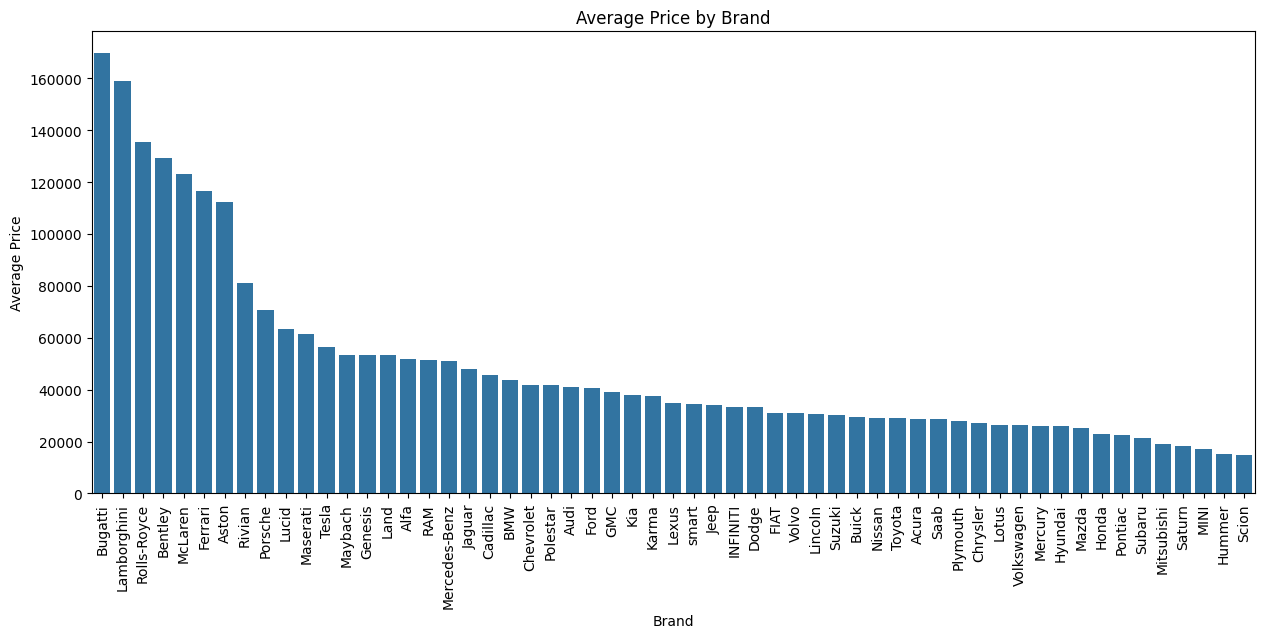

In [14]:
brand_price = df_train.groupby('brand')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(x=brand_price.index, y=brand_price.values)
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.title('Average Price by Brand')
plt.xticks(rotation=90)
plt.show()

In [15]:
def brand_encoder(brand):
    brand_mapping = {
        3: ['Bugatti', 'Lamborghini', 'Rolls-Royce', 'Bentley', 'McLaren', 'Ferrari', 'Aston'],
        2: ['Rivian', 'Porsche', 'Lucid', 'Maserati', 'Tesla', 'Maybach', 'Genesis', 'Land', 'Alfa', 'RAM', 'Mercedes-Benz', 'Jaguar', 'Cadillac', 'BMW'],
    }

    # Iterate through the mapping and return the  value
    for rating, brands in brand_mapping.items():
        if brand in brands:
            return rating

    # Return 1 if the brand isn't found in the mapping
    return 1

df_train['brand_encoded'] = df_train['brand'].apply(brand_encoder)
df_test['brand_encoded'] = df_test['brand'].apply(brand_encoder)


In [16]:
print('encoded_train' ,df_train['brand_encoded'].unique())
print('encoded_test ' ,df_test ['brand_encoded'].unique())

encoded_train [1 2 3]
encoded_test  [2 1 3]


In [17]:
## brand will be dropped after encoding it
df_train  = df_train.drop('brand', axis=1)
df_test  = df_test.drop('brand', axis=1)

In [18]:
df_train['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', 'Electricity', 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

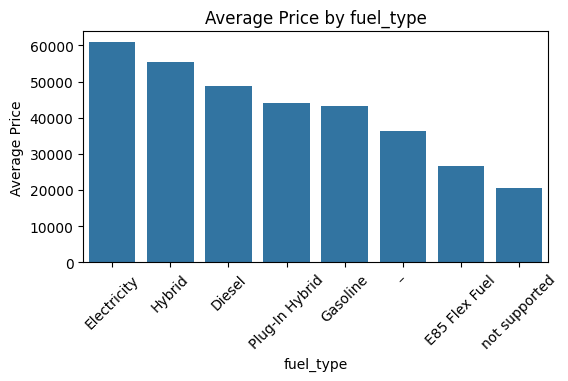

In [19]:
fuel_price = df_train.groupby('fuel_type')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(6, 3))
sns.barplot(x=fuel_price.index, y=fuel_price.values)
plt.xlabel('fuel_type')
plt.ylabel('Average Price')
plt.title('Average Price by fuel_type')
plt.xticks(rotation=45)
plt.show()

In [20]:
## we will encode feul_types as we encoded brands before :
def fuel_encoder(fuel_type):
    fuel_mapping = {
        3: ['Electricity', 'Hybrid','Diesel' ],
        2:  ['Plug-In Hybrid','Gasoline','–'],
    }

    # Iterate through the mapping and return the  value
    for rating, types in fuel_mapping.items():
        if fuel_type in types:
            return rating

    # Return 1 if the brand isn't found in the mapping
    return 1

df_train['fuel_type'] = df_train['fuel_type'].apply(fuel_encoder)
df_test['fuel_type'] = df_test['fuel_type'].apply(fuel_encoder)

In [21]:
print('encoded_train' ,df_train['fuel_type'].unique())
print('encoded_test ' ,df_test ['fuel_type'].unique())


encoded_train [2 1 3]
encoded_test  [2 3 1]


In [22]:
df_train['engine']

0              172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel
1              252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel
2         320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...
3              420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel
4              208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
                                ...                        
188528         420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel
188529        385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel
188530         469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel
188531                                                 3.0L
188532         252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel
Name: engine, Length: 188533, dtype: object

In [23]:
# we will use regular expressions (regex) to extract some features from it as :-
# [Horsepower,Displacement,Engine Type,Cylinder Count,Fuel Type] :
import re

def extract_hp(engine):
    match = re.search(r'(\d+(\.\d+)?)HP', engine)
    return float(match.group(1)) if match else None

def extract_displacement(engine):
    match = re.search(r'(\d+\.\d+)L|(\d+\.\d+) Liter', engine)
    return float(match.group(1)) if match else None

def extract_engine_type(engine):
    match = re.search(r'(V\d+|I\d+|Flat \d+|Straight \d+)', engine)
    return match.group(1) if match else None

def extract_cylinder_count(engine):
    match = re.search(r'(\d+) Cylinder', engine)
    return int(match.group(1)) if match else None

def extract_fuel_type(engine):
    fuel_types = ['Gasoline', 'Diesel', 'Electric', 'Hybrid', 'Flex Fuel']
    for fuel in fuel_types:
        if fuel in engine:
            return fuel
    return None

def extract_displacement(engine):
    match = re.search(r'(\d+\.\d+)L|(\d+\.\d+) Liter', engine)
    if match:
        return float(match.group(1)) if match.group(1) else float(match.group(2))
    return None

# Apply extraction functions on train & test :
df_train['Horsepower'] = df_train['engine'].apply(extract_hp)
df_train['Displacement'] = df_train['engine'].apply(extract_displacement)
df_train['Engine Type'] = df_train['engine'].apply(extract_engine_type)
df_train['Cylinder Count'] = df_train['engine'].apply(extract_cylinder_count)
df_train['Fuel Type'] = df_train['engine'].apply(extract_fuel_type)


df_test['Horsepower'] = df_test['engine'].apply(extract_hp)
df_test['Displacement'] = df_test['engine'].apply(extract_displacement)
df_test['Engine Type'] = df_test['engine'].apply(extract_engine_type)
df_test['Cylinder Count'] = df_test['engine'].apply(extract_cylinder_count)
df_test['Fuel Type'] = df_test['engine'].apply(extract_fuel_type)

In [24]:
# handel null values in Horse Power and Cylinder count with mean :

df_train['Horsepower'].fillna(df_train['Horsepower'].mean(), inplace=True)
df_train['Cylinder Count'].fillna(df_train['Cylinder Count'].mean(), inplace=True)

df_test['Horsepower'].fillna(df_test['Horsepower'].mean(), inplace=True)
df_test['Cylinder Count'].fillna(df_test['Cylinder Count'].mean(), inplace=True)

In [25]:
df_train.head()

,id,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,brand_encoded,Horsepower,Displacement,Engine Type,Cylinder Count,Fuel Type
0,0,2007,213000,2,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,1,172.0,1.6,None,4.0,Gasoline
1,1,2002,143250,2,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,1,252.0,3.9,None,8.0,Gasoline
2,2,2002,136731,1,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,1,320.0,5.3,None,8.0,Flex Fuel
3,3,2017,19500,2,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,2,420.0,5.0,None,8.0,Gasoline
4,4,2021,7388,2,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,2,208.0,2.0,None,4.0,Gasoline


In [26]:
df_train.drop(['engine','Fuel Type'], axis=1, inplace=True)
df_test.drop(['engine','Fuel Type'], axis=1, inplace=True)

In [27]:
df_train['Engine Type'].isnull().sum()

np.int64(99563)

In [28]:
df_train.drop(['Engine Type'], axis=1, inplace=True)
df_test.drop(['Engine Type'], axis=1, inplace=True)

In [29]:
## transmission feature :
df_train['transmission'].unique()

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '10-Speed Automatic', '1-Speed A/T', '6-Speed A/T',
       '10-Speed A/T', '9-Speed A/T', '8-Speed Automatic',
       '9-Speed Automatic', '5-Speed A/T', 'Automatic',
       '7-Speed Automatic with Auto-Shift', 'CVT Transmission',
       '5-Speed M/T', 'M/T', '6-Speed M/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T', '2-Speed A/T',
       '1-Speed Automatic', 'Automatic CVT', '4-Speed A/T',
       '6-Speed Manual', 'Transmission Overdrive Switch',
       '8-Speed Automatic with Auto-Shift', '7-Speed Manual',
       '7-Speed Automatic', '9-Speed Automatic with Auto-Shift',
       '6-Speed Automatic with Auto-Shift',
       '6-Speed Electronically Controlled Automatic with O', 'F', 'CVT-F',
       '8-Speed Manual', 'Manual', '–', '2', '6 Speed At/Mt',
       '5-Speed Automatic', '2-Speed Automatic', '8-SPEED A/T', '7-Speed',
       'Variable', 'Single-Speed Fixed Gear', '8-SPEED AT',


In [30]:
'''
transmission_map = {
    'manual': 'Manual',
    'm/t': 'Manual',
    'automatic': 'Automatic',
    'a/t': 'Automatic',
    'cvt': 'CVT'
}
'''
def clean_transmission(value):
    value = value.strip().lower()  # Convert to lowercase and strip whitespace
    if 'manual' in value or 'm/t' in value:
        return 'Manual'
    elif 'automatic' in value or 'a/t' in value or 'cvt' in value:
        return 'Automatic'
    elif 'cvt' in value:
        return 'CVT'
    else:
        return 'Other'

# Apply the cleaning function
df_train['transmission'] = df_train['transmission'].apply(clean_transmission)
df_test['transmission'] = df_test['transmission'].apply(clean_transmission)

df_train['transmission'].unique()

array(['Automatic', 'Other', 'Manual'], dtype=object)

In [31]:
df_train.head(3)

,id,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,brand_encoded,Horsepower,Displacement,Cylinder Count
0,0,2007,213000,2,Automatic,Yellow,Gray,None reported,Yes,4200,1,172.0,1.6,4.0
1,1,2002,143250,2,Automatic,Silver,Beige,At least 1 accident or damage reported,Yes,4999,1,252.0,3.9,8.0
2,2,2002,136731,1,Automatic,Blue,Gray,None reported,Yes,13900,1,320.0,5.3,8.0


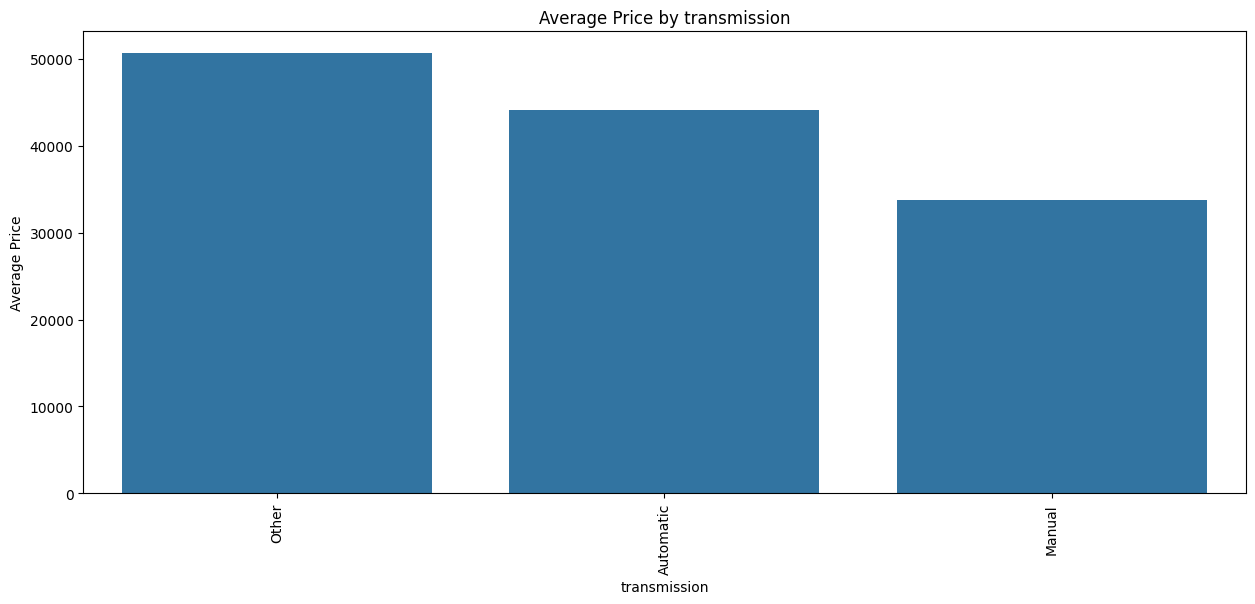

In [32]:
# transmission will be encoded based on price :-
transmission_price = df_train.groupby('transmission')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(x=transmission_price.index, y=transmission_price.values)
plt.xlabel('transmission')
plt.ylabel('Average Price')
plt.title('Average Price by transmission')
plt.xticks(rotation=90)
plt.show()

In [33]:
def transmission_encoder(transmission):
  if transmission in ['Other' ]:
    return 3
  elif transmission in ['Automatic']:
    return 2
  else:
    return 1

df_train['transmission'] = df_train['transmission'].apply(transmission_encoder)
df_test ['transmission'] = df_test ['transmission'].apply(transmission_encoder)

In [34]:
df_train.head(3)

,id,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,brand_encoded,Horsepower,Displacement,Cylinder Count
0,0,2007,213000,2,2,Yellow,Gray,None reported,Yes,4200,1,172.0,1.6,4.0
1,1,2002,143250,2,2,Silver,Beige,At least 1 accident or damage reported,Yes,4999,1,252.0,3.9,8.0
2,2,2002,136731,1,2,Blue,Gray,None reported,Yes,13900,1,320.0,5.3,8.0


In [35]:
df_train['ext_col'].nunique()

319

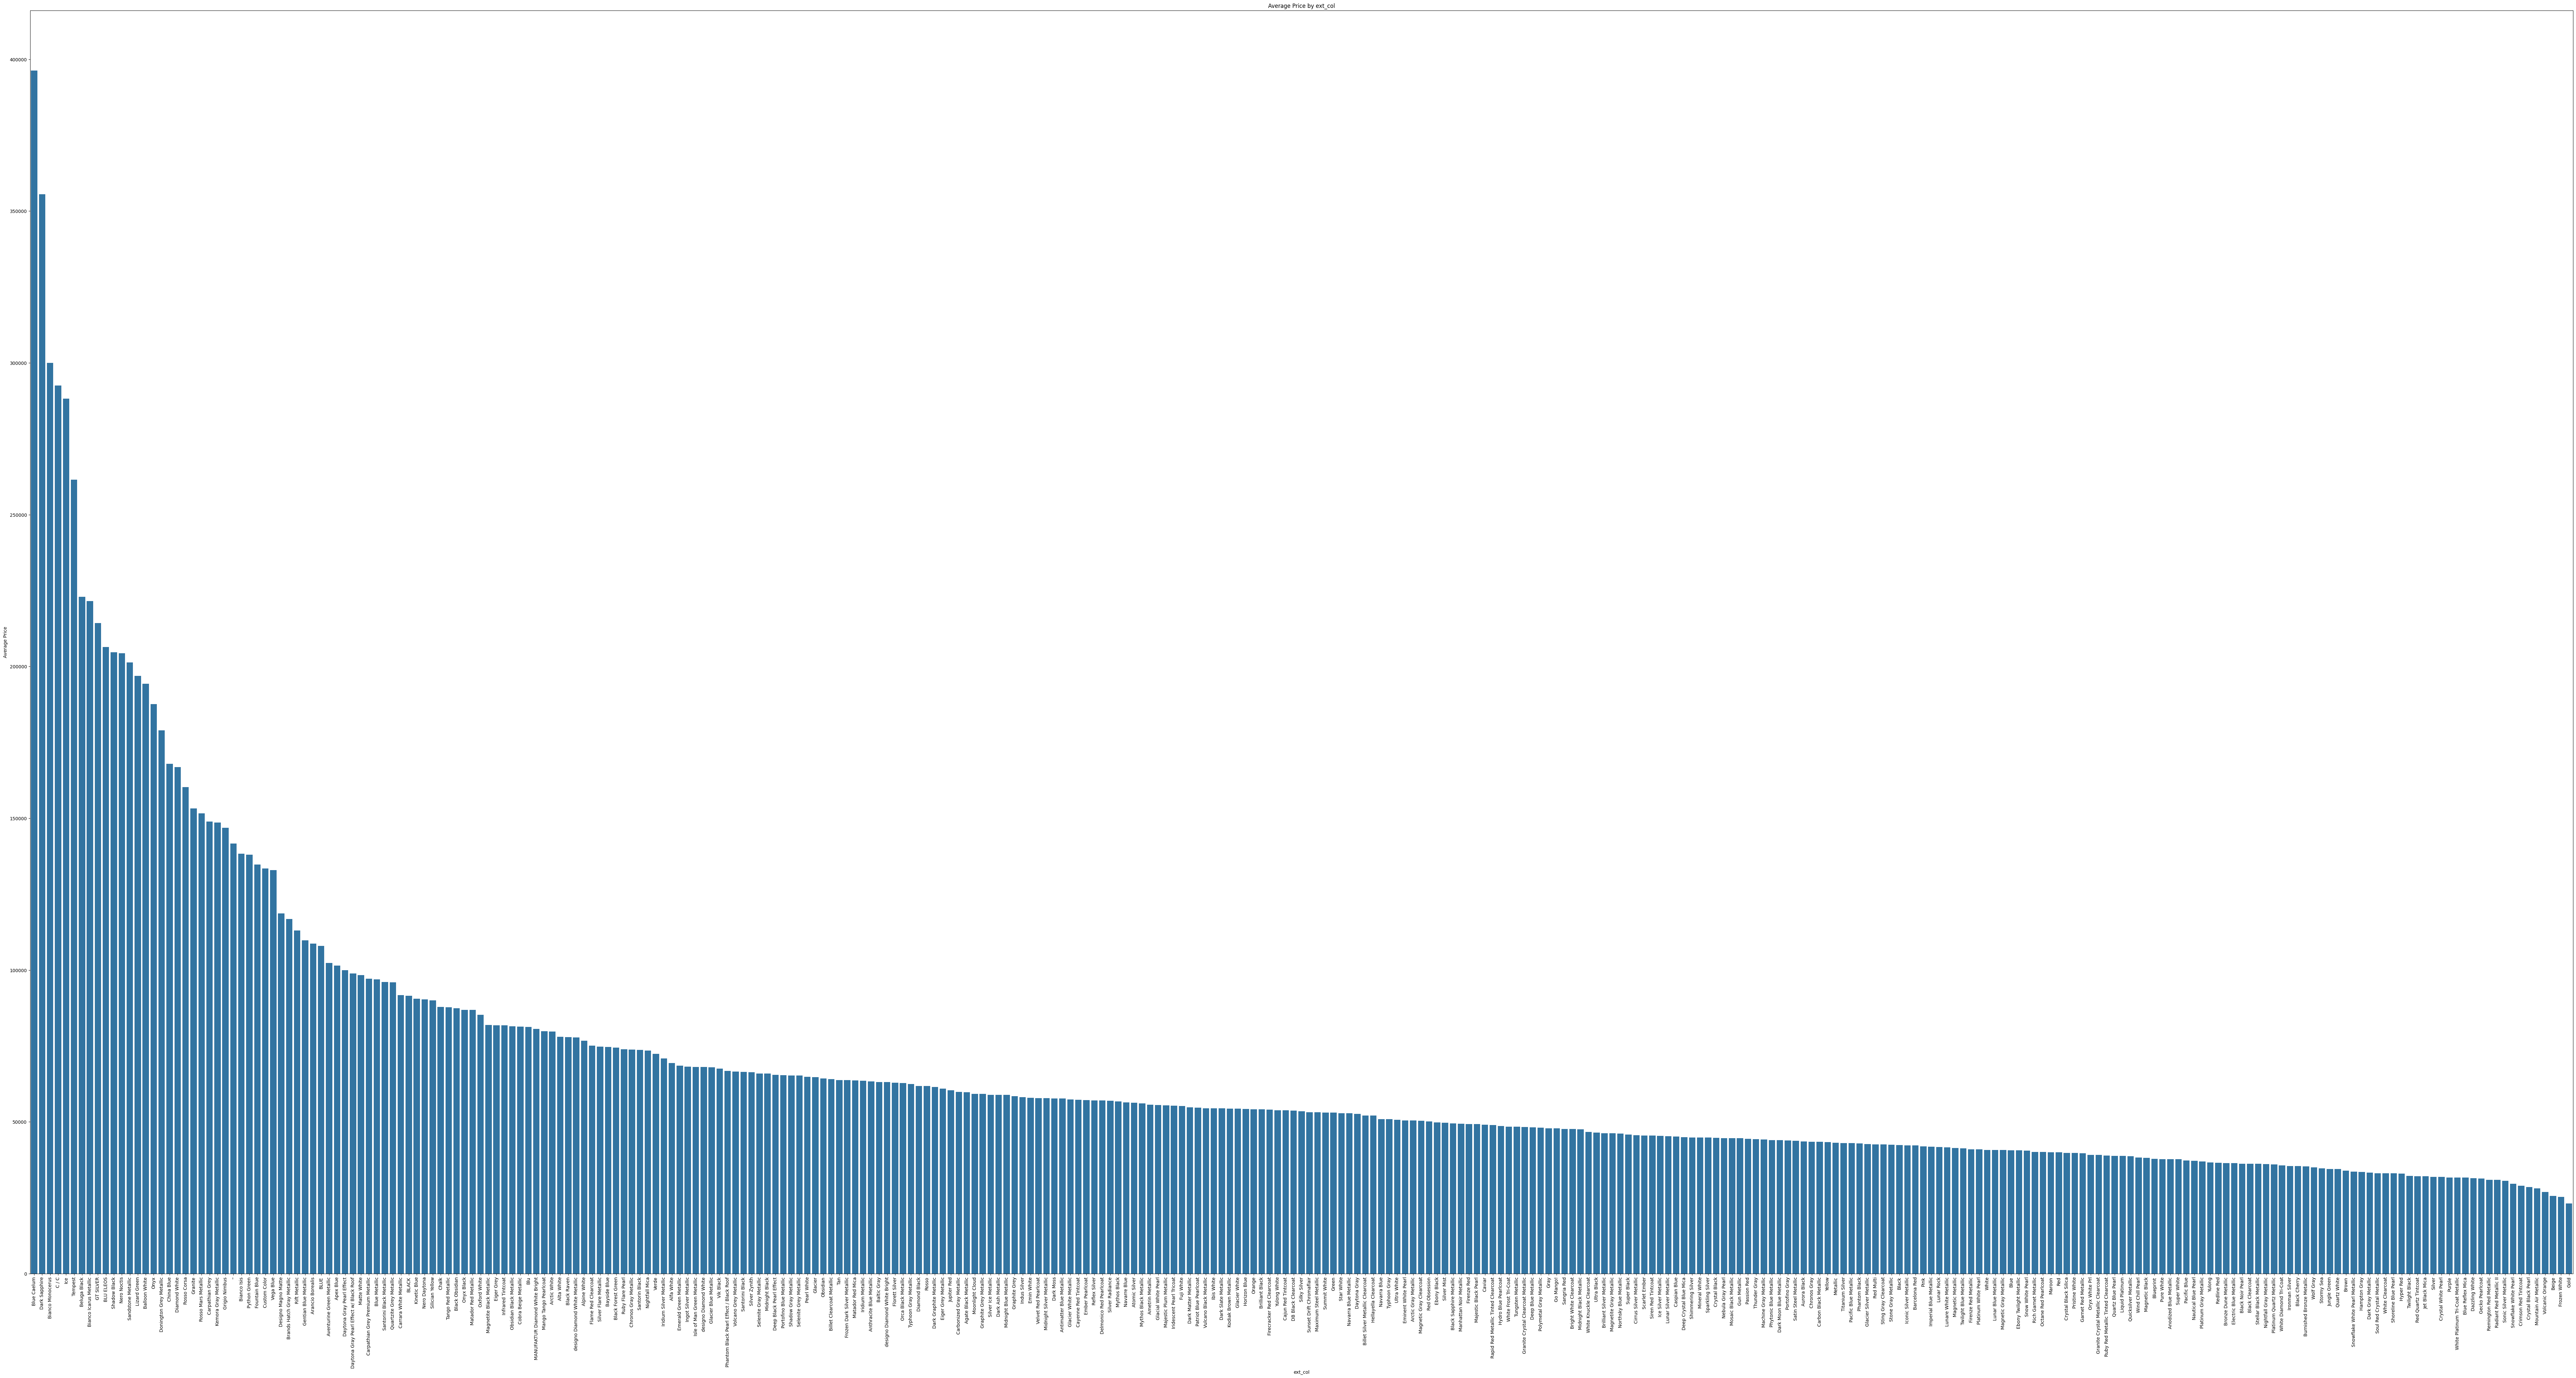

In [36]:
ext_col_price = df_train.groupby('ext_col')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(100,50))
sns.barplot(x=ext_col_price.index, y=ext_col_price.values)
plt.xlabel('ext_col')
plt.ylabel('Average Price')
plt.title('Average Price by ext_col')
plt.xticks(rotation=90)
plt.show()

In [37]:
# Calculate mean price per color and sort
ext_col_price = df_train.groupby('ext_col')['price'].mean().sort_values(ascending=False)

# color ranked based on its mean of price :
color_rank = {color: rank for rank, color in enumerate(ext_col_price.index, start=1)}

# Encode the colors
df_train['ext_col_encoded'] = df_train['ext_col'].map(color_rank)
df_test['ext_col_encoded'] = df_test['ext_col'].map(color_rank)

df_train.drop('ext_col', axis=1, inplace=True)
df_test.drop('ext_col', axis=1, inplace=True)

In [38]:
print(df_train['ext_col_encoded'].isna().sum())
print(df_test['ext_col_encoded'].isna().sum())

0
0


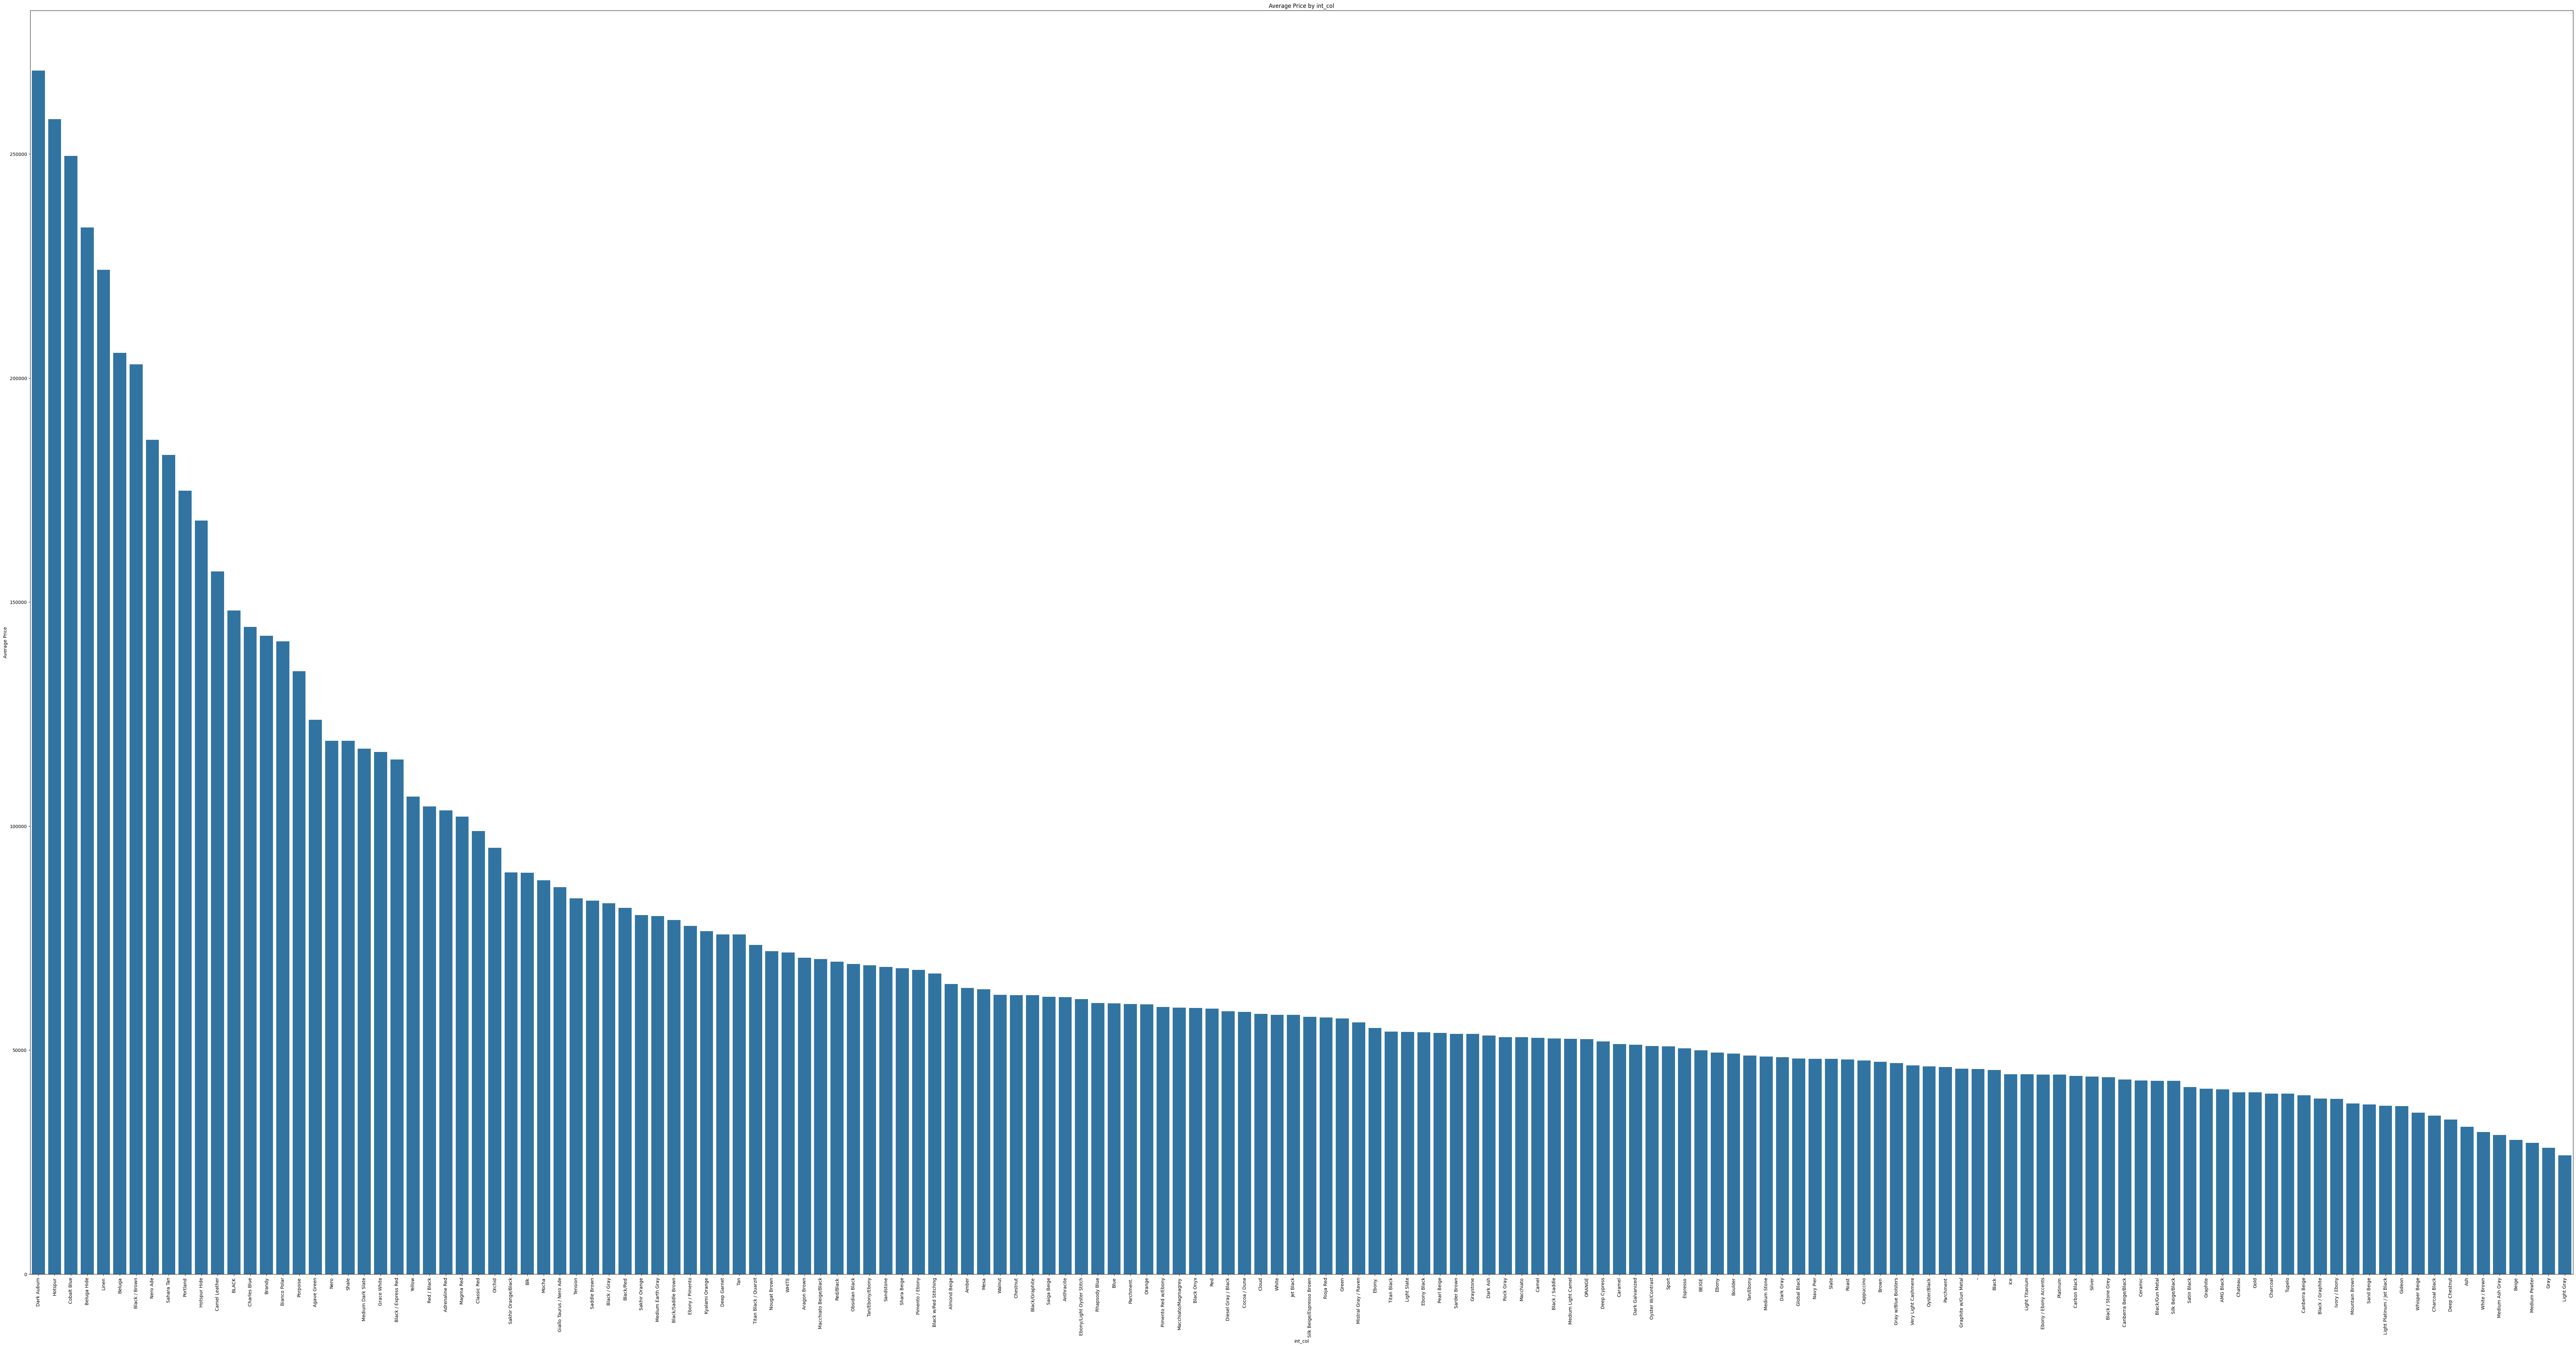

In [39]:
## we will make the same steps on int_col as we did on ext_col :
int_col_price = df_train.groupby('int_col')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(100,50))
sns.barplot(x=int_col_price.index, y=int_col_price.values)
plt.xlabel('int_col')
plt.ylabel('Average Price')
plt.title('Average Price by int_col')
plt.xticks(rotation=90)
plt.show()

In [40]:
# Arrange the colors from highest to lowest based on price , then encode it
int_col_price = df_train.groupby('int_col')['price'].mean().sort_values(ascending=False)

color_rank = {color: rank for rank, color in enumerate(int_col_price.index, 1)}

df_train['int_col_encoded'] = df_train['int_col'].map(color_rank)
df_test['int_col_encoded'] = df_test['int_col'].map(color_rank)

df_train.drop('int_col', axis=1, inplace=True)
df_test.drop('int_col', axis=1, inplace=True)

In [41]:
print(df_train['int_col_encoded'].isna().sum())
print(df_test['int_col_encoded'].isna().sum())

0
0


In [42]:
df_train.head(3)

,id,model_year,milage,fuel_type,transmission,accident,clean_title,price,brand_encoded,Horsepower,Displacement,Cylinder Count,ext_col_encoded,int_col_encoded
0,0,2007,213000,2,2,None reported,Yes,4200,1,172.0,1.6,4.0,226,155
1,1,2002,143250,2,2,At least 1 accident or damage reported,Yes,4999,1,252.0,3.9,8.0,302,153
2,2,2002,136731,1,2,None reported,Yes,13900,1,320.0,5.3,8.0,249,155


In [43]:
## accident feature :
df_train['accident'].unique()


array(['None reported', 'At least 1 accident or damage reported'],
      dtype=object)

In [44]:
# Define a mapping for the accident types
accident_mapping = {
    'None reported': 0,
    'At least 1 accident or damage reported': 1
}

# Apply the encoding
df_train['accident_encoded'] = df_train['accident'].map(accident_mapping)
df_test['accident_encoded'] = df_test['accident'].map(accident_mapping)


In [45]:
print(df_train['accident'].isna().sum())
print(df_test ['accident'].isna().sum())

0
0


In [46]:
df_train.drop('accident', axis=1, inplace=True)
df_test.drop('accident', axis=1, inplace=True)

In [47]:
# clean_title feature :
df_train['clean_title'].unique()

array(['Yes', 'No'], dtype=object)

In [48]:
def clean_title_encoder(clean_title):
  if clean_title in ['Yes']:
    return 1
  elif clean_title in ['No']:
    return 0

df_train['clean_title'] = df_train['clean_title'].apply(clean_title_encoder)
df_test['clean_title'] = df_test['clean_title'].apply(clean_title_encoder)

In [49]:
df_train.head(3)


,id,model_year,milage,fuel_type,transmission,clean_title,price,brand_encoded,Horsepower,Displacement,Cylinder Count,ext_col_encoded,int_col_encoded,accident_encoded
0,0,2007,213000,2,2,1,4200,1,172.0,1.6,4.0,226,155,0
1,1,2002,143250,2,2,1,4999,1,252.0,3.9,8.0,302,153,1
2,2,2002,136731,1,2,1,13900,1,320.0,5.3,8.0,249,155,0


In [50]:
#  replace model_year column with the age of the car as (model_age) :-

current_year = 2024

df_train['model_age'] = current_year - df_train['model_year']
df_test['model_age'] = current_year - df_test['model_year']

df_train.drop('model_year', axis=1, inplace=True)
df_test.drop('model_year', axis=1, inplace=True)

In [51]:
cat_cols = [x for x in df_train.columns if df_train[x].dtype == 'object']
num_cols = [x for x in df_train.columns if df_train[x].dtype != 'object']
print('Categorical : ',cat_cols)
print('Numerical : ',num_cols)

Categorical :  []
Numerical :  ['id', 'milage', 'fuel_type', 'transmission', 'clean_title', 'price', 'brand_encoded', 'Horsepower', 'Displacement', 'Cylinder Count', 'ext_col_encoded', 'int_col_encoded', 'accident_encoded', 'model_age']


In [52]:
for col in num_cols:
  Q1 = df_train[col].quantile(0.25)
  Q3 = df_train[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  df_train[col] = np.clip(df_train[col], lower_bound, upper_bound)


In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])


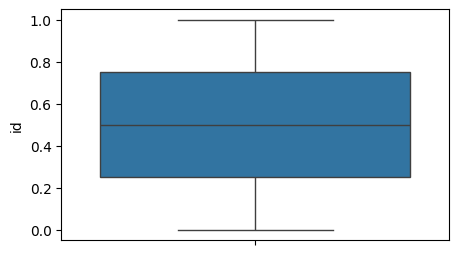

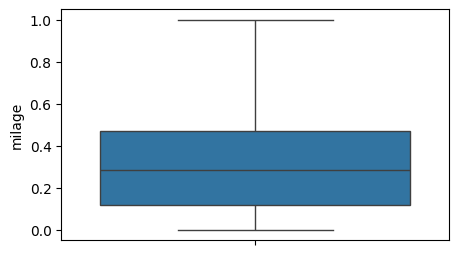

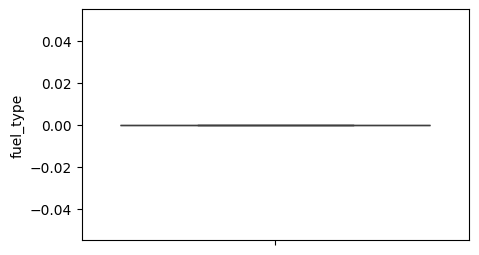

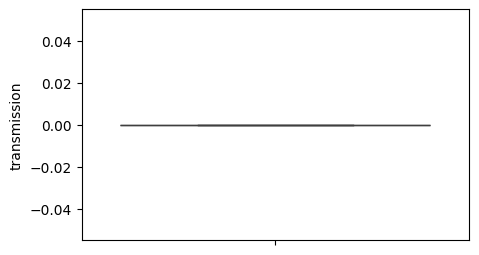

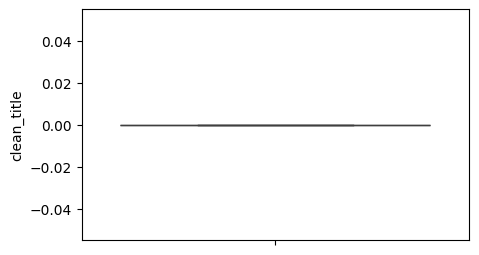

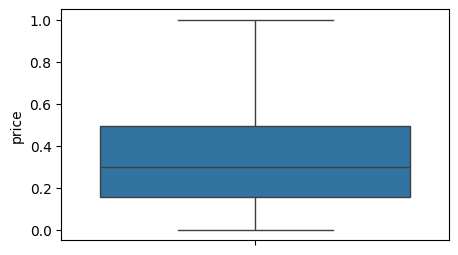

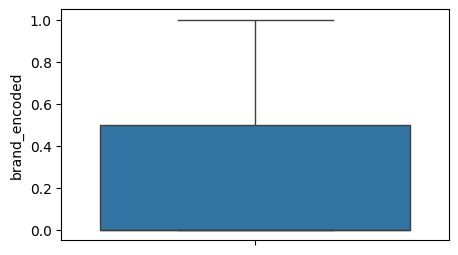

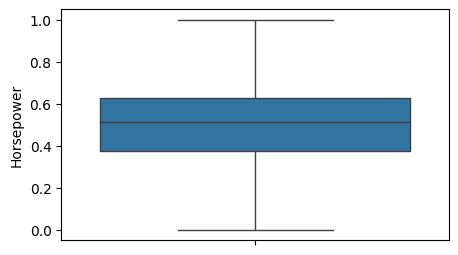

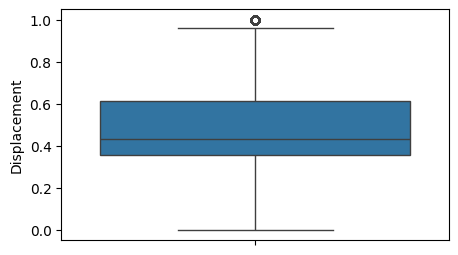

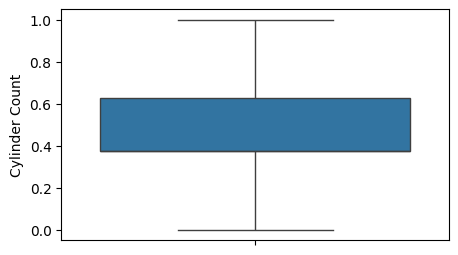

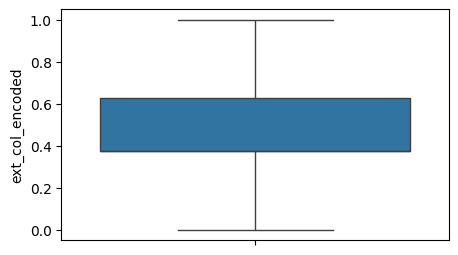

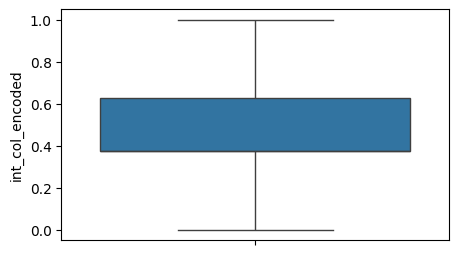

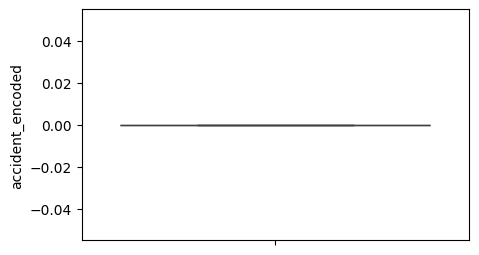

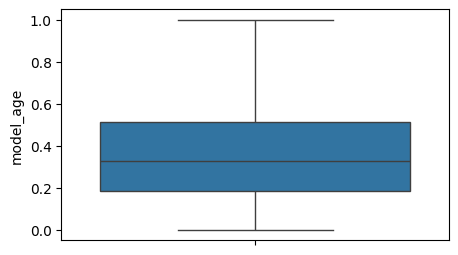

In [54]:
for x in num_cols:
  plt.figure(figsize=(5,3))
  sns.boxplot(df_train[x])

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'milage'}>,
        <Axes: title={'center': 'fuel_type'}>,
        <Axes: title={'center': 'transmission'}>],
       [<Axes: title={'center': 'clean_title'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'brand_encoded'}>,
        <Axes: title={'center': 'Horsepower'}>],
       [<Axes: title={'center': 'Displacement'}>,
        <Axes: title={'center': 'Cylinder Count'}>,
        <Axes: title={'center': 'ext_col_encoded'}>,
        <Axes: title={'center': 'int_col_encoded'}>],
       [<Axes: title={'center': 'accident_encoded'}>,
        <Axes: title={'center': 'model_age'}>, <Axes: >, <Axes: >]],
      dtype=object)

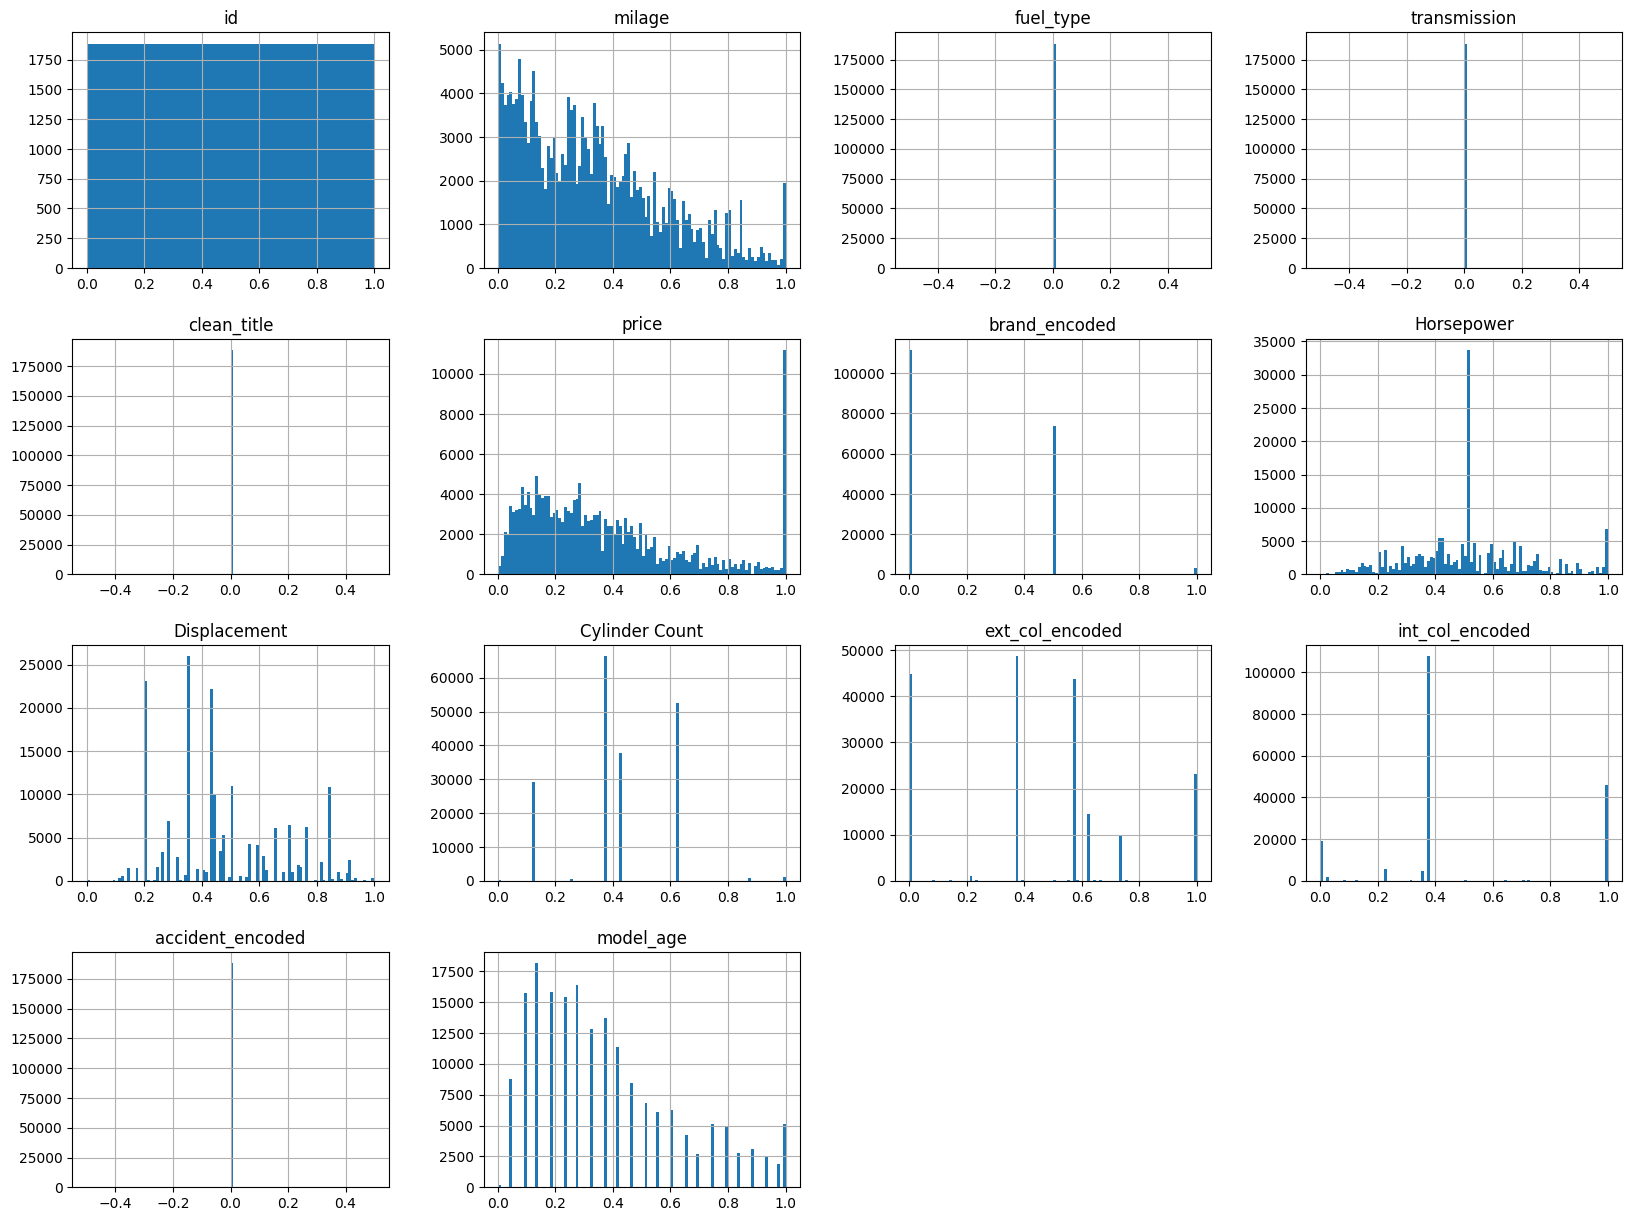

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
df_train[num_cols].hist(bins = 100, figsize = (20, 15))

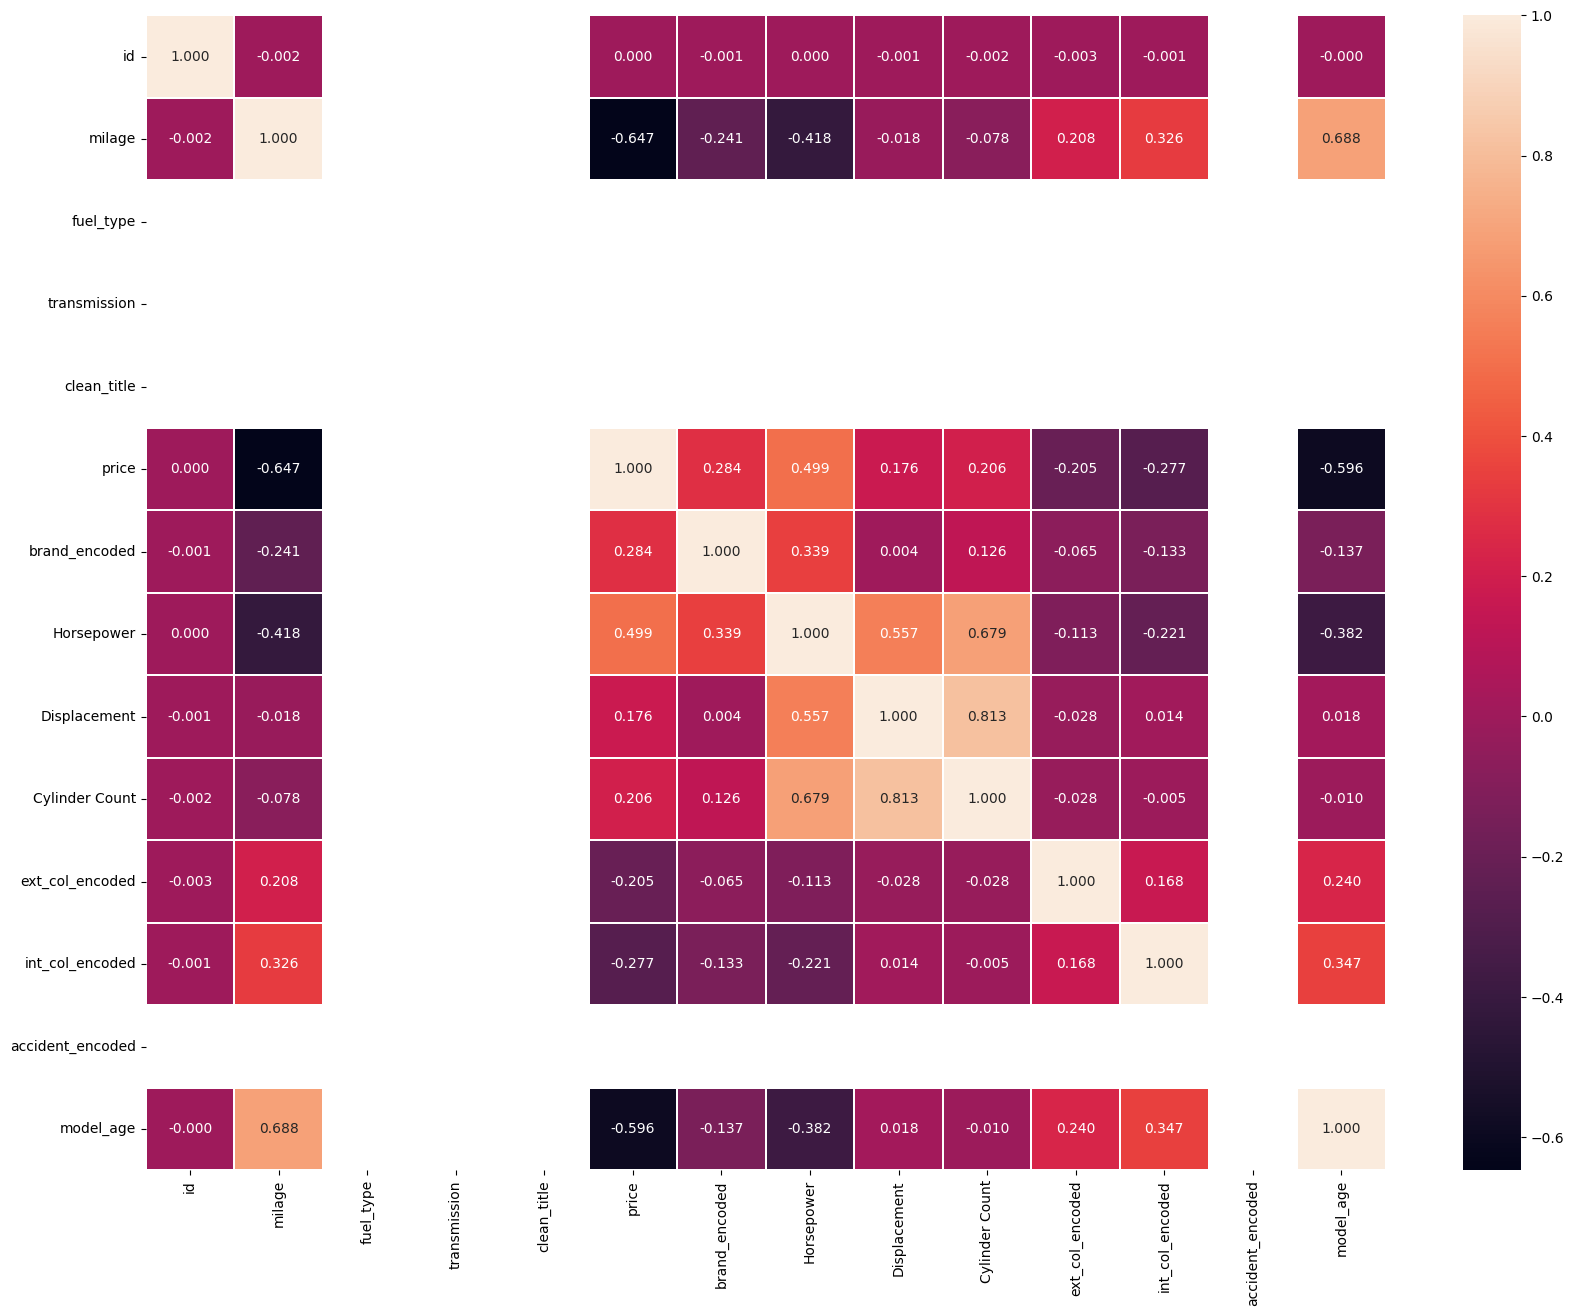

In [56]:
corr_matrix = df_train[num_cols].corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix,
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values,
            linewidth=0.1,
            annot=True,  # This will show the correlation values on the graph
            fmt=".3f")
plt.show()

In [57]:
df_train.drop('Displacement', axis=1, inplace=True)
df_test.drop('Displacement', axis=1, inplace=True)

In [58]:
# create csv files for new df_train and df_test
df_train.to_csv('df_train_processed2.csv', index=False)
df_test.to_csv('df_test_processed2.csv', index=False)

In [59]:
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)


In [60]:
x = df_train.drop(['price'], axis=1)
y = df_train['price']

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

**LinearRegression**

In [62]:
model1 = LinearRegression()


In [63]:
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

In [64]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [65]:
print(f"R-squared: {r2:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")


R-squared: 0.516388
Mean Squared Error (MSE): 0.034351
Root Mean Squared Error (RMSE): 0.185341
Mean Absolute Error (MAE): 0.139543


In [66]:
y_pred = model1.predict(df_test)

df_submission['price'] = y_pred

df_submission.to_csv('submission2.csv', index=False)

**XGBRegressor**

In [67]:
model2 = xgb.XGBRegressor(n_estimatorsn_estimators=2000,max_depth=6,eta=0.13 )

In [68]:
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

In [69]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [70]:
print(f"R-squared: {r2:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

R-squared: 0.606968
Mean Squared Error (MSE): 0.027917
Root Mean Squared Error (RMSE): 0.167085
Mean Absolute Error (MAE): 0.116010


In [71]:
#lasso algorithm
from sklearn.linear_model import Lasso
model4= Lasso(alpha=0.07,max_iter=2000)
#fit the model to the data
model4.fit(X_train,y_train)
y_pred=model4.predict(X_test)


In [72]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [73]:
print(f"R-squared: {r2:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

R-squared: -0.000007
Mean Squared Error (MSE): 0.071032
Root Mean Squared Error (RMSE): 0.266517
Mean Absolute Error (MAE): 0.211910


**SVR**

In [74]:
# from sklearn.svm import SVR
# model3 = SVR()

In [75]:
# model3.fit(X_train, y_train)
# y_pred = model3.predict(X_test)

In [76]:
# mse = mean_squared_error(y_test, y_pred)
# rmse = mse ** 0.5
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

In [77]:
# print(f"R-squared: {r2:.6f}")
# print(f"Mean Squared Error (MSE): {mse:.6f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
# print(f"Mean Absolute Error (MAE): {mae:.6f}")